In [1]:
import tensorflow as tf
import numpy as np
import os
import time


In [2]:
lst = []

with open('../data/full_tab_string.txt') as small_pf:

    tmp_list = []
    for line in small_pf:
        line = line.rstrip("\n")
        if line == "":
            lst.append(tmp_list)
            tmp_list = []
        else:
            tmp_list.extend(line.split())

    if tmp_list:  # add last one
        lst.append(tmp_list)
lst = lst[0]

In [3]:
text = ""
with open('../data/full_tab_string.txt') as small_pf:
    text = small_pf.read()

In [4]:
#Can't use set because tab encodings are not hashable types
def unique(list1):
    unique_set = set()
    for x in list1:
        if x not in unique_set:
            unique_set.add(x)
    return unique_set

In [5]:
#list of all tab locations
tab_vocab = unique(lst)

In [6]:
ids_from_chars = tf.keras.layers.StringLookup(
    num_oov_indices = 1, 
    vocabulary=list(tab_vocab), 
    mask_token=None)
print(ids_from_chars.get_vocabulary())

['[UNK]', 'G22', 'e5', 'G24', 'A9', 'E14', 'E3', 'B14', 'E55', 'A6', 'G99', 'D77', 'D9', 'A7', 'G10', 'e18', 'A15', 'D19', 'G81', 'D0', 'G91', 'D17', 'G2', 'B20', 'E22', 'E33', 'E7', 'e0', 'G5', 'E77', 'E13', 'e17', 'e77', 'e20', 'D13', 'B9', 'D7', 'G18', 'G19', 'G0', 'B88', 'B18', 'G12', 'G17', 'D4', 'e24', 'B31', 'e4', 'G9', 'e1', 'D3', 'B5', 'E11', 'D22', 'B8', 'e10', 'D14', 'E19', 'G42', 'B6', 'e15', 'B10', 'e6', 'B3', 'A54', 'D2', 'D1', 'A11', 'G4', 'A57', 'e9', 'B19', 'B4', 'G16', 'G15', 'E16', 'e11', 'e71', 'A22', 'E12', 'e28', 'D75', 'A33', 'E1', 'B21', 'G21', 'G61', 'A2', 'e14', 'B13', 'E57', 'E4', 'e8', 'G1', 'e7', 'D10', 'B11', 'B51', 'A19', 'A16', 'G14', 'B16', 'A17', 'B12', 'e21', 'B22', 'e51', 'G3', 'E17', 'e16', 'A12', 'E9', 'A77', 'A25', 'G8', 'E0', 'G92', 'A8', 'G6', 'G7', 'e22', 'B0', 'G40', 'D6', 'B2', 'A4', 'e3', 'D11', 'B33', 'A3', 'D12', 'B24', 'A14', 'A75', 'D8', 'D25', 'A45', 'e23', 'B17', 'G13', 'B71', 'D5', 'E6', 'A44', 'B53', 'E10', 'A0', 'E5', 'D15', 'G11', 

In [7]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)


In [8]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids) + " ", axis=-1)

In [9]:
all_ids = ids_from_chars(tf.strings.split(text))

In [10]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
type(ids_dataset)

tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset

In [11]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

D7
G5
B5
e5
e7
D6
B5
G5
e7
e8


In [12]:
seq_length = 20

In [13]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
print(type(sequences))
for seq in sequences.take(1):
  print(chars_from_ids(seq))
  print(type(seq))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
tf.Tensor(
[b'D7' b'G5' b'B5' b'e5' b'e7' b'D6' b'B5' b'G5' b'e7' b'e8' b'D5' b'B5'
 b'G5' b'e8' b'e2' b'D4' b'B3' b'G2' b'e2' b'e0' b'D3'], shape=(21,), dtype=string)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [14]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'D7 G5 B5 e5 e7 D6 B5 G5 e7 e8 D5 B5 G5 e8 e2 D4 B3 G2 e2 e0 D3 '
b'B1 G2 B1 e0 B1 G2 B0 G0 A2 B1 G2 A0 B1 G2 A0 G2 A0 A8 A7 A0 D7 '
b'G5 B5 e7 D6 B5 G5 e7 e8 D5 B5 G5 e8 e2 D4 B3 G2 e2 e0 D3 B1 G2 '
b'B1 e0 B1 G2 B0 G0 A2 B1 G2 A0 B1 G2 A0 A0 A2 A3 D2 G0 e0 e2 D0 '
b'B3 G2 e2 e0 D3 B1 G2 e0 B0 A0 B1 G2 A0 A2 B1 A3 G0 D2 B1 e3 E3 '


In [15]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [23]:
split_input_target(sequences)

TypeError: 'BatchDataset' object is not subscriptable

In [16]:
dataset = sequences.map(split_input_target)
dataset



<MapDataset element_spec=(TensorSpec(shape=(20,), dtype=tf.int64, name=None), TensorSpec(shape=(20,), dtype=tf.int64, name=None))>

In [17]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'D7 G5 B5 e5 e7 D6 B5 G5 e7 e8 D5 B5 G5 e8 e2 D4 B3 G2 e2 e0 '
Target: b'G5 B5 e5 e7 D6 B5 G5 e7 e8 D5 B5 G5 e8 e2 D4 B3 G2 e2 e0 D3 '


In [18]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 20), dtype=tf.int64, name=None), TensorSpec(shape=(64, 20), dtype=tf.int64, name=None))>

In [19]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [20]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)

    #adjust the dense units size                         
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [21]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [23]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 20, 173) # (batch_size, sequence_length, vocab_size)


In [24]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  44288     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  177325    
                                                                 
Total params: 4,159,917
Trainable params: 4,159,917
Non-trainable params: 0
_________________________________________________________________


In [25]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [26]:
sampled_indices

array([ 14, 122, 132,  93,  85, 116,  54, 135, 143,  78, 143,  75, 139,
        52, 134,  58,  89,  68, 100, 118], dtype=int64)

In [27]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'D7 e2 B3 G4 A2 D7 e2 B3 G4 A2 D7 e3 B5 G5 A3 D4 e3 B5 G5 A3 '

Next Char Predictions:
 b'G10 G40 A14 G1 G21 G92 B8 D25 A44 A22 A44 E16 G13 E11 D8 G42 B13 G4 G14 G6 '


In [28]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [29]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 20, 173)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(5.154606, shape=(), dtype=float32)


In [30]:
model.compile(optimizer='adam', loss=loss)

In [34]:
# Directory where the checkpoints will be saved
checkpoint_dir = './tab_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [35]:
EPOCHS = 4

In [36]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/4
130/130 [==============================] - 31s 225ms/step - loss: 3.3786
Epoch 2/4
130/130 [==============================] - 29s 223ms/step - loss: 2.4908
Epoch 3/4
130/130 [==============================] - 29s 224ms/step - loss: 2.1554
Epoch 4/4
130/130 [==============================] - 30s 232ms/step - loss: 1.8408


In [42]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.

    #USE THIS TO CHANGE WHICH OUTPUTS ARE ALLOWED
    skip_ids = self.ids_from_chars(['[UNK]', 'G22', 'e5', 'G24', 
    'A9', 'E14', 'E3', 'B14', 'E55', 'A6', 'G99', 'D77', 'D9', 
    'A7', 'G10', 'e18', 'A15', 'D19', 'G81', 'D0', 'G91', 'D17', 
    'G2', 'B20', 'E22', 'E33', 'E7', 'e0', 'G5', 'E77', 'E13', 
    'e17', 'e77', 'e20', 'D13', 'B9', 'D7', 'G18', 'G19', 'G0', 
    'B88', 'B18', 'G12', 'G17', 'D4', 'e24', 'B31', 'e4', 'G9', 
    'e1', 'D3', 'B5', 'E11', 'D22', 'B8', 'e10', 'D14', 'E19', 
    'G42', 'B6', 'e15', 'B10', 'e6', 'B3', 'A54', 'D2', 'D1', 
    'A11', 'G4', 'A57', 'e9', 'B19', 'B4', 'G16', 'G15', 'E16', 
    'e11', 'e71', 'A22', 'E12', 'e28', 'D75', 'A33', 'E1', 'B21', 
    'G21', 'G61', 'A2', 'e14', 'B13', 'E57', 'E4', 'e8', 'G1', 
    'e7', 'D10', 'B11', 'B51', 'A19', 'A16', 'G14', 'B16', 'A17', 
    'B12', 'e21', 'B22', 'e51', 'G3', 'E17', 'e16', 'A12', 'E9', 
    'A77', 'A25', 'G8', 'E0', 'G92', 'A8', 'G6', 'G7', 'e22', 'B0', 
    'G40', 'D6', 'B2', 'A4', 'e3', 'D11', 'B33', 'A3', 'D12', 'B24', 
    'A14', 'A75', 'D8', 'D25', 'A45', 'e23', 'B17', 'G13', 'B71', 
    'D5', 'E6', 'A44', 'B53', 'E10', 'A0', 'E5', 'D15', 'G23', 
    'E2', 'e13', 'B23', 'E8', 'A52', 'A5', 'E34', 
    'A13', 'A99', 'e19', 'G20', 'B1', 'D52', 'D20', 'A1', 'E15', 'B15', 
    'e12', 'A10'])[:, None]

    # skip_ids = self.ids_from_chars('[UNK]', 'G3', 'B22', 'E3', 'B11', 
    # 'G5', 'e22', 'A9', 'G19', 'D2', 'G21', 'E4', 'D16', 'E14', 'D7', 
    # 'G14', 'G17', 'D6', 'B0', 'e3', 'A4', 'G81', 'D19', 'D4', 'D14', 
    # 'E2', 'G11', 'B2', 'B18', 'e18', 'E13', 'B14', 'G16', 'A0', 'E15', 
    # 'E6', 'e2', 'e7', 'E11', 'B5', 'B4', 'e15', 'A8', 'D8', 'G6', 'D13', 
    # 'G4', 'A16', 'B15', 'B7', 'B3', 'A12', 'A17', 'E8', 'e23', 'B9', 
    # 'A15', 'e4', 'E19', 'A5', 'D15', 'D5', 'B1', 'A10', 'A7', 'e8', 
    # 'e19', 'B13', 'A19', 'D11', 'D12', 'D17', 'e24', 'B6', 'A2', 'A3', 
    # 'A6', 'e13', 'e16', 'B24', 'e1', 'e10', 'G2', 'G1', 'G8', 'A11', 
    # 'G12', 'E17', 'e20', 'G13', 'B17', 'D1', 'E10', 'e12', 'B19', 'D10',
    #  'B20', 'A13', 'e5', 'G10', 'G0', 'E0', 'B12', 'e0', 'e14', 
    #  'A14', 'G9', 'B16', 'A1', 'e9', 'D3', 'e6', 'B8', 'A33', 'G7', 
    #  'E5', 'D9', 'e11', 'e17', 'E1', 'E9', 'B21', 'B10', 'G18', 'E12', 
    #  'D0', 'e21', 'E7', 'G15')
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [43]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [47]:
#get more than 3 Epochs to decrease loss for better predictions. This is, i believe the perfect basis 
#for getting tab to work.
histthis = []
for i in range(100):
  states = None
  next_char = tf.constant(['D9 D11 G9'])
  result = [next_char + " "]
  for n in range(1):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char + " ")

  result = tf.strings.join(result)

  if result[0].numpy().decode('utf-8') == 'D9 D11 G9 G11 ':
    histthis.append(0)
  elif result[0].numpy().decode('utf-8') == 'D9 D11 G9 B7 ':
    histthis.append(1)
  elif result[0].numpy().decode('utf-8') == 'D9 D11 G9 e2 ':
    histthis.append(2)
  elif result[0].numpy().decode('utf-8') == 'D9 D11 G9 d16 ':
    histthis.append(3)
print(result[0].numpy().decode('utf-8'))

D9 D11 G9 B7 


In [48]:
histthis

[1,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1]

The model appears to be successfully predicting, but the fact that it predicts an e2 here consistantly is not good. Will need to clean things up and check what is going on. I could be testing things wrong. Not sure. 

(array([ 9.,  0.,  0.,  0.,  0., 58.,  0.,  0.,  0., 22.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

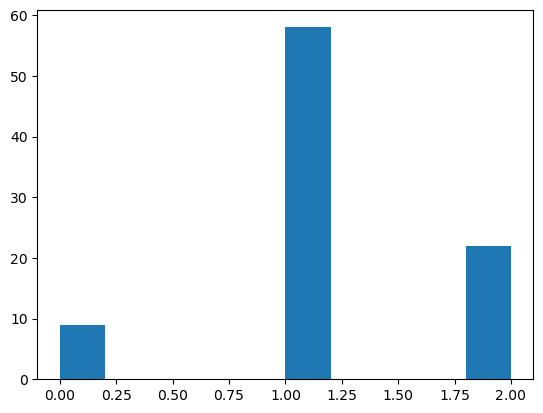

In [49]:
import matplotlib.pyplot as plt
plt.hist(histthis)